In [1]:
export PYTHONPATH="/cs/cs152/individual/ishita:$PYTHONPATH"

SyntaxError: invalid syntax (1275362780.py, line 1)

In [2]:
cd ..

/mnt/cs/cs152/individual/ishita


In [3]:
import sys

root_path = '/cs/cs152/individual/ishita/checkpoints/'

if root_path not in sys.path:
    sys.path.insert(1, root_path)
    
from models.pcvae import PredictionConstrainedVAE
from utils.vistools import * 
from scripts.train_pcvae import loadData

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm



2024-10-07 22:39:36.061736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 22:39:37.099589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
saved_model = "TBD" # !!TBD
pcvae = PredictionConstrainedVAE(architecture="linear", latent_dims=20, num_classes=10).to(device)


DATASET_NAME = "MNIST"
NUM_TRAIN = 100
BATCH_SIZE = 128
data_l, data_u = loadData(DATASET_NAME, NUM_TRAIN) 
dataLoader_l = DataLoader(data_l, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_u = DataLoader(data_u, batch_size=BATCH_SIZE, shuffle=False)

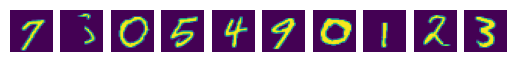

In [28]:
images, labels = next(iter(dataLoader_l))

# Display the images
fig, axes = plt.subplots(1, 10)
for i in range(10):
    axes[i].imshow(images[i].permute(1, 2, 0))  # Permute to get correct channel order
    axes[i].axis('off')

plt.show()

In [8]:
class EncodedDataset(Dataset):
    def __init__(self, dataset, encode_fn, device):
        self.dataset = dataset
        self.encode_fn = encode_fn
        self.device = device
        self.encoded_images = []
        self.labels = []

        # Encode all images beforehand and store them
        for image, label in tqdm(dataset):
            encoded_image = self.encode_fn(image, device)
            self.encoded_images.append(encoded_image)
            self.labels.append(label)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.encoded_images[idx], self.labels[idx]

def encode(x, device):
    with torch.no_grad():
        pcvae.encoder.eval()
        x = x.to(device)
        mean, logvar = pcvae.encoder(x.to(device))
        
        # Sample an image from the distribution
        z = pcvae.encoder.sample(mean, logvar)
        z = z.detach()
        
        return z
    
encoded_train_data = EncodedDataset(data_l, encode, device)
encoded_val_data = EncodedDataset(data_u, encode, device)
print(f'Encoded train data shape: {encoded_train_data[0][0].shape}')

train_dataLoader = DataLoader(encoded_train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataLoader = DataLoader(encoded_val_data, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 69900/69900 [00:30<00:00, 2291.33it/s]

Encoded train data shape: torch.Size([1, 20])


In [9]:
def validate(model, dataLoader, device, input_size, loss_fn):
    model.eval()
    accurate = 0
    total = 0
    dl_losses = []

    with torch.no_grad():
        for images,labels in dataLoader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)
    
            output = model(images)
            _,predicted = torch.max(output.data, 1)
    
            # compute loss
            dl_losses.append(loss_fn(output, labels).item())
            
            # total labels
            total += labels.size(0)
            
            # total correct predictions
            accurate += (predicted == labels).sum().item()
    
    accuracy_score = 100 * accurate/total
    return np.mean(dl_losses), accuracy_score

In [10]:
validate(pcvae.classifier, train_dataLoader, device=device, input_size=20, loss_fn=nn.CrossEntropyLoss())

(2.4241747856140137, 9.0)

In [11]:
z_batches, y_batches = get_latent(pcvae, dataLoader_u, num_batches=100, latent_dims=20, device='cuda')

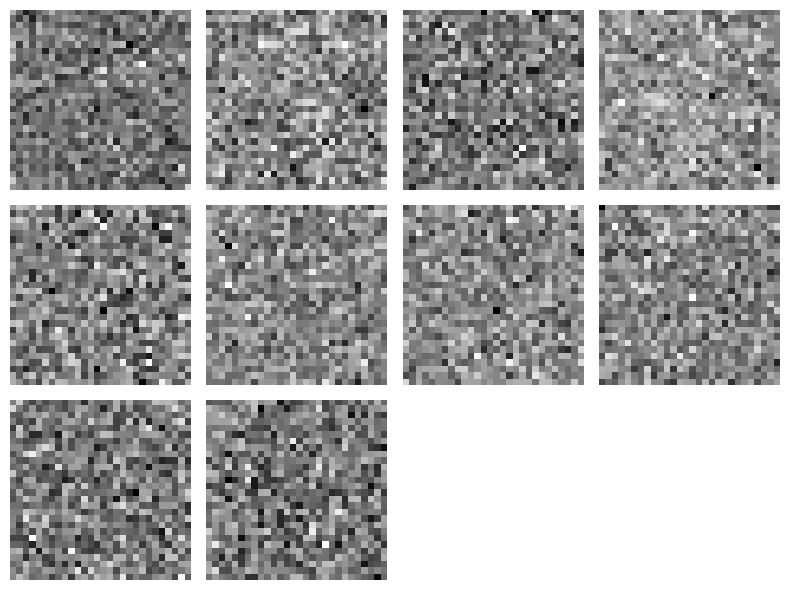

In [12]:
sample_random(pcvae, n=10)

In [13]:
import sys

root_path = '/cs/cs152/individual/ishita/checkpoint'

if root_path not in sys.path:
    sys.path.insert(1, root_path)
    
from models.vae import VariationalAutoencoder
from utils.vistools import * 
from scripts.train_pcvae import loadData

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
pcvae = PredictionConstrainedVAE(architecture="linear", latent_dims=20, num_classes=10)

In [20]:
saved_model = "/cs/cs152/individual/ishita/checkpoints/pcvae_weighted-PCvae-MNIST-linear-20-1-0.001-2024-10-07-20-34-09"

In [21]:
state_dict = torch.load(saved_model)
pcvae.load_state_dict(state_dict)
pcvae.eval()
pcvae.to(device)

PredictionConstrainedVAE(
  (encoder): LinearEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=20, bias=True)
    (linear3): Linear(in_features=512, out_features=20, bias=True)
  )
  (decoder): LinearDecoder(
    (linear1): Linear(in_features=20, out_features=512, bias=True)
    (linear2_mu): Linear(in_features=512, out_features=784, bias=True)
  )
  (classifier): LogisticRegression(
    (linear): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [22]:
pcvae.classifier

LogisticRegression(
  (linear): Linear(in_features=20, out_features=10, bias=True)
)

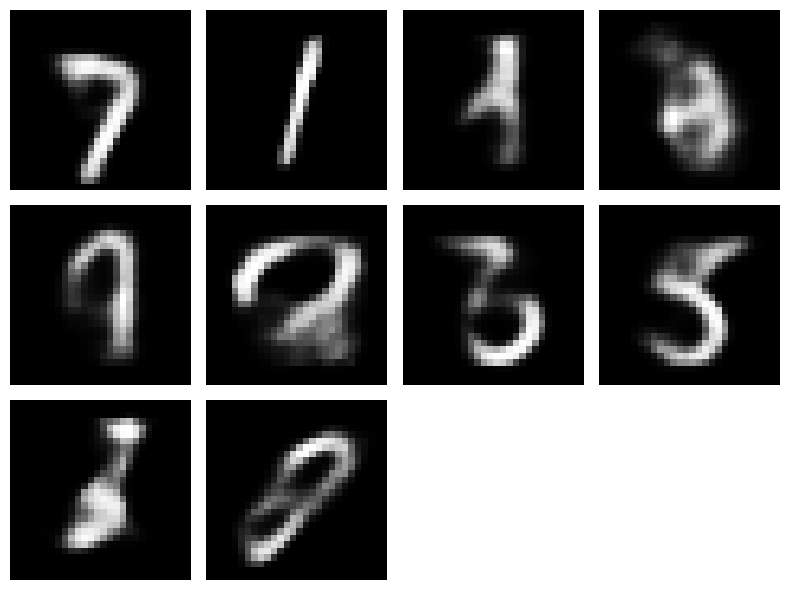

In [23]:
sample_random(pcvae, n=10)